In [1]:
# REDACT
import numpy as np
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer

from scipy import stats


# The Bayes-Sics
If you've spent any time in a stats-adjacent environment, you may have head heard whispers of the bitter rivalry between the two noble houses of statistics: the [frequentists](https://en.wikipedia.org/wiki/Frequentist_inference) and the [Bayesians](https://en.wikipedia.org/wiki/Bayesian_inference). These two contrasting schools of thought offer different philosophical frameworks for modeling our understanding of the world, with each offering an entire independent corpus of statistical tools. Frequentism, the sort of statistics most often taught in highschool, and is spun out of the fundamental question: _"how likely are the things I observe to have come from coincidence"_. This is the first and most important question in simple yes/no hypothesis testing. Does a particular drug lower blood pressure, yes or no? Does a prediction do significantly better than a random guess, yes or no?  Bayesian modeling, by contrast, asks the similar but subtly distinct question _"Given what I __already__ know about the world, how likely is a particular fact to be true?"_. 

Most introductions to Bayesianism, typically centered around examples of medical diagnostics, focus on how it invokes its central feature of the [prior](https://en.wikipedia.org/wiki/Prior_probability), i.e. what we knew about the world _before_ we got a particular batch of experimental data. However, physics is often concerned less about categorical yes/no questions and more about fitting models of reality and constraining their parameters. There are certain tell-tale distinctions between Bayesian and frequentist approaches in this world of model fitting. In this article, I'll start by contrasting the two approaches for a simple linear regression to highlight the different blueprints for how they attack a problem. From there I introduce Bayesianism's own yes/no hypothesis testing involving [Bayesian Model Evidence](https://en.wikipedia.org/wiki/Bayes_factor), and then the more approximate form of the [Bayesian Information Criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion). 

##  A Simple Example - Linear Regression
To kick things off, lets look at the simplest model example of model fitting we can imagine: fitting a straight line to some 2D data. Really, this problem is two distinct questions:
1. Does the data show a _significant_ linear relationship? i.e. is this relationship more convincing than the variables being independent?
2. What line, if any, describes this relationship?

As a realistic example, lets suppose we measure the height (in cm) and weight (in kg) of $N=64$ adult men drawn randomly from the population. Tall people can be skinny, short people can be stocky, but we broadly expect taller people to, on average, get heavier the taller they are. For both frequentist and Bayesian approaches, we're basically saying that height ($H$) and weight ($W$) are related by:

$$
W = m \cdot H + c \pm \epsilon
$$

Where $m$ and $c$ are some slope and offset, and $\epsilon$ is some sort of inherent scatter about that line. 
> Note that this isn't the _only_ way to model this relationship, but its a nice simple one that most readers are familiar with.

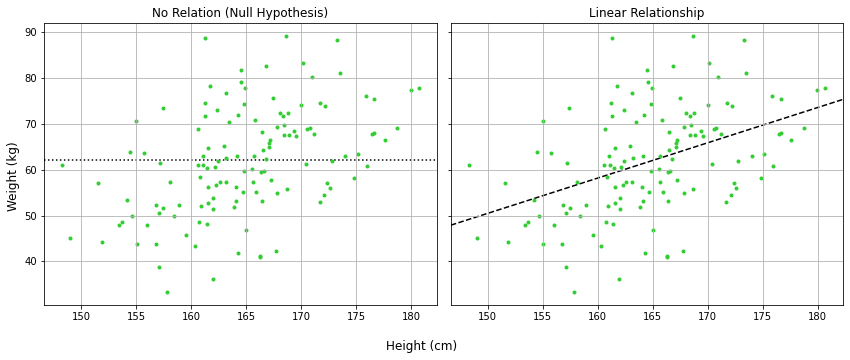

In [2]:
# REDACT
np.random.seed(11)
N  = 128
hav, hsig = 165, 6.8
wav, wsig = 62, 12
correl = 0.435
COVAR = np.array([
    [hsig**2, correl * hsig * wsig], 
    [correl * hsig * wsig, wsig**2]
])
H, W  = np.random.multivariate_normal(mean = np.array([hav,wav]), cov=COVAR, size=N).T

#--------------------

f, (a1,a2) = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True)
for a in (a1,a2):
    a.scatter(H,W, marker='.', c='limegreen')
    a.grid()
    
f.supxlabel("Height (cm)" ), f.supylabel("Weight (kg)")

a1.set_title("No Relation (Null Hypothesis)"), a2.set_title("Linear Relationship")
a1.axline((hav,wav), slope=0.0 * wsig/hsig, ls=':', c='k', zorder=-1)
a2.axline((hav,wav), slope=correl * wsig/hsig, ls='--', c='k', zorder=-1)
f.tight_layout()
plt.show()

### A Frequentist Approach
Frequentism works with the twin-tools of the *estimator* and the *p-value*, in essence asking firstly for some estimate of the model: 
1. _"From the data, what is a good guess of my model parameters?"_,

And then some measure of improvement:

3. _"For these parameters, how much better is my model than the null hypothesis?"_

And finally, a test of significance:

4. _"What is the probability this improvement can happen from pure random luck?"_.

The central theme of frequentism is to **start with the data** and then use it to **work backwards** towards parameters. Only then do we use test statistics to check how well we did after the fact. This is frequentism's greatest strength: it offers a broad set of easy to use tools with most problems having a simple plug-and-play method for fitting and checking. This is also its greatest weakness: you always need to find the _particular_ tools for the job, and make sure that it's actually answering the question you care about. 

<p style="text-align: center;">
    <img src="./media/flowchart_freq.png" width="75%">
</p>

**Model 1: No Relation (Null Hypothesis)**  
Let's look at our stationary model. For data *without error bars*, the are some clean and simple estimators for the mean and standard deviation:

$$
\mu = \frac{1}{N} \sum_i {x_i}, \;\;\;\; \sigma^2 = \frac{1}{N-1} \sum_i \left( {x_i}-\mu \right)^2
$$

I won't inflict on you the gory details of how these are derived, but in brief they come from asking "_If I calculate this number, what distribution of values could I get from random chance_", and then "_does the average of this distribution line up with the thing I want to estimate?_". Once equipped with these, we can calculate the **residuals** of this model, the amount that each $x_i$ differs from $\mu$:

$$
r_{1,i} = W_i-\mu
$$

These residuals always average-out to zero: our model should over-estimate just as often as it under-estimates. Their _variance_, however, tells us about the total scatter of the data about the model, a rough measure of the "badness of fit":

$$
\mathrm{Var}_1 =  \frac{1}{N} \sum_i r_i^2
$$

In [3]:
mufreq = W.sum()/N
sigmafreq  = np.sqrt(((W-mufreq)**2).sum() / (N-1))
var_1 = sigmafreq**2
print("mean and std for weight are ~ %.2f and %.2f, with variance %.2f." %(mufreq, sigmafreq, var_1))

mean and std for weight are ~ 61.86 and 11.70, with variance 136.84.


**Model 2: Linear Regression**  
Now let's look at our linear regression. Again, we have on-hand some nice and easy to use estimators that you'll find in any first year lab manual. Slope and offset are estimated by:

$$
m = \frac{\sum_i{ \left( H-\bar{H} \right)\left( W-\bar{W} \right)}}{\sum_i{ \left( H-\bar{H} \right)\left( H-\bar{H} \right)}}, \;\;\;
c = \bar{W} - m \bar{H}
$$

Where the averages are:

$$
\bar{H} = \frac{1}{N} \sum_i{H_i}, \;\;\; \bar{W} = \frac{1}{N} \sum_i{W_i}
$$

Again, we can calculate the residuals to see how much / often the linear fit misses the data:

$$
r_{2,i} = W_i-(m\cdot H_i + c)
$$

Like before, the variance of these residuals tells us about the scatter data about the linear fit. When this number if small, it means we've _explained_ a lot of the variance in the data:

$$
\mathrm{Var}_2 =  \frac{1}{N} \sum_i r_{2,i}^2
$$

In [4]:
xbar, ybar = H.mean(), W.mean()
mfreq = np.sum((H-xbar) * (W-ybar)) /  np.sum((H-xbar)**2)
cfreq = -xbar * mfreq + ybar
resid = W - ( H * mfreq + cfreq)
var_2 = np.sum(resid**2) / (N-1)

print("best estimate for slope and offset are ~ %.2f and %.2f and with variance %.2f." %(mfreq, cfreq, var_2))

best estimate for slope and offset are ~ 0.81 and -71.90 and with variance 108.25.


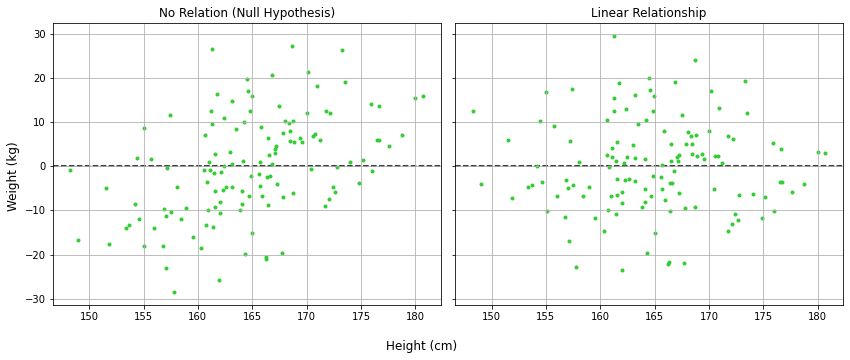

In [5]:
# REDACT
np.random.seed(11)
N  = 128
hav, hsig = 165, 6.8
wav, wsig = 62, 12
correl = 0.435
COVAR = np.array([
    [hsig**2, 0.435 * hsig * wsig], 
    [0.435 * hsig * wsig, wsig**2]
])
H, W  = np.random.multivariate_normal(mean = np.array([hav,wav]), cov=COVAR, size=N).T

#--------------------

f, (a1,a2) = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True)
for a in (a1,a2):
    a.grid()
    a.axhline(0, ls='--', c='k', zorder=-1)
    
a1.scatter(H, W-mufreq, marker='.', c='limegreen')
a2.scatter(H, W - (mfreq * H + cfreq), marker='.', c='limegreen')

    
f.supxlabel("Height (cm)" ), f.supylabel("Weight (kg)")

a1.set_title("No Relation (Null Hypothesis)"), a2.set_title("Linear Relationship")
#a1.axline((hav,wav), slope=0.0 * wsig/hsig, ls=':', c='k', zorder=-1)
#a2.axline((hav,wav), slope=0.435 * wsig/hsig, ls='--', c='k', zorder=-1)
f.tight_layout()
plt.show()

**Testing Our Model**

So, we've fit our linear regression and found that it decreases variance / residuals / amount of scatter by about one half. Now the really important question: "_is that a lot?_". a sloped line has more degrees of freedom than a flat line, it can always angle itself to fit the data at least a little bit better, so we need a way to test whether this is a meaningful improvement. A brute-force way would be to use [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)): scrambling our data again and again to remove the relationship and seeing how often we get a result that strong. This is a sort of low cost dollar-store alternative to actually repeating the experiment many times, but is a little unwieldy.

Fortunately, we have a much more elegant solution: the [F-Test](https://en.wikipedia.org/wiki/F-test). The F-test essentially cuts to the punchline and answers: "_What is the probability that these two residuals have the same scatter?"_ in a nice closed form. First, we calculate a **test statistic**:

$$
F = \frac{\mathrm{Explained \; Variance}}{\mathrm{Unexplained \; Variance}}
$$

Which we then feed into the F-test itself, basically a black box. You'll notice in the code snippet below we also track the degrees of freedom in each model: models with more dials to tune can fit the data better so we need to penalize them here.

In [6]:
# Calculate the F-statistic
f_value = var_2 / var_1

# Calculate the degrees of freedom
df1 = len(H) - 1
df2 = len(H) - 2

# Calculate the p-value
p_value = stats.f.cdf(f_value, df1, df2)

print("For variance %.2f and %.2f, F=%.2f. For %i and %i degrees of freedom, this gives p = %.2e" %(var_1, var_2, f_value, df1, df2, p_value))

For variance 136.84 and 108.25, F=0.79. For 127 and 126 degrees of freedom, this gives p = 9.43e-02


Great! Our linear model did much better at explaining the data, and there is only an $\approx 0.5\%$ chance that this improvement came from random chance. We reject the null hypothesis (no correlation) and retain the new hypothesis (linear fit with our estimates for $m$ and $c$). This is the basis of pretty much all frequentist model fitting: estimate the model, measure some metric for goodness of fit, and then use _some_ kind of test to measure the odds of coincidence. 

Note that there was no rule handed down from above that a straight line was a good model, or that the variance of the residuals was the best way to describe how well we did, but having some test for significance lets us pave over all these somewhat arbitrary decisions by squashing it all down into a single p-value that tells us how well these choices performed.

Frequentism's greatest strength is that it works "out of the box" without much complication. We didn't care about exactly _how_ the residuals looked, just how big they are. As long as you can frame your null hypothesis correctly, there's almost always some sort of existing test you can use to get a p-value. Where it becomes less powerful is in asking how _tightly_ we know our parameters: how similar can slopes and offsets be and still fit our data decently well? What if we wanted to add in another new variable, or got some new data? We'd need to restart our analysis from scratch and with possibly completely different tools. 

### A Bayesian Approach

The central idea of a Bayesian approach is the **generative model**, basically the procedure you'de use if you wanted to _simulate_ your data. We give that model some **parameters** that we can tune, and then fiddle with them to get our simulated data to line up with our observed data. This is the complete opposite of frequenstim, here we **start with the parameters** and **work forwards** to generate data, and then compare to observations to validate.

<p style="text-align: center;">
    <img src="./media/flowchart_bayes.png" width="50%">
</p>

If frequentism is all about the probability of coincidence, Bayesianism is about the probability of explanation. At its core, it states:  

<center><i>"The probability of a model being true is proportional to its ability to reproduce our observations."</i></center>

In the abstract, we say that the probability that some statement $\theta$ is true (e.g. some model parameters, a binary statement etc) given some observational data $D$ is equal to the probability of that statement being true before the data (the "prior" $\pi(\theta)$) times the probability that we'd get those observations if the statement were true (the likelihood $\mathcal{L}(D\vert\theta)$).

$$
P(\theta \vert D) \propto \pi(\theta)\times\mathcal{L}(D\vert\theta)
$$

Instead of trying to slog through Bayesian modelling in these non-specific generalities, we'll get our hands dirty on a simple model and learn the moving parts as they come in. 

**Model 1: Stationary**  
In our frequentist approach, our null hypothesis was as simple as there being no relation between height and weight. In Bayesian modeling, we need to be much more explicit about how the data behaves. For example, instead of just saying "there is no relationship between weight and height", we need to go as far as to say "the weights are fully described by a normal distribution with some mean $\mu$ and width $\sigma$":

$$
W_i \sim \mathcal{N}(\mu, \sigma)
$$

We need to be this explicit because it lets us say how likely a particular measurement is given some model parameters: the so called _likelihood_ of that event. The likelihood of any _one_ measurement $W_i$ is, for some values of $\mu$ and $\sigma$:

$$
\mathcal{L}_i(\mu, \sigma) = P(W_i\vert\mu,\sigma)= \frac{1}{\sqrt{2\pi\sigma^2}}  \exp{\left(- \frac{1}{2} \left( \frac{W_i-\mu}{\sigma} \right)^2 \right)}
$$

And the total probability of this model producing _all_ of our observations, i.e. the overall __likelihood__ of our data, is just the product of these for all our data:

$$
\mathcal{L}(\mu, \sigma) = P(\{W_i\} \vert \mu, \sigma) = \prod_i \frac{1}{\sqrt{2\pi\sigma^2}}  \exp{ \left( -\frac{1}{2} \left( \frac{W_i-\mu}{\sigma} \right)^2 \right)}
$$

If we wanted to simulate some data, we'd punch in values for $\mu$ and $\sigma$ and draw "realizations" of $\{W_i\}$ from that distribution. This likelihood is the beating heart of a Bayesian model: parameters that have a high likelihood of reproducing our our observations also have a high probability of being correct. 

For the sake of mathematical convenience, we can also re-arrange this to a neater form:

$$
\mathcal{L}(\mu, \sigma) = \exp{\left( -\frac{1}{2} \sum_i \left(  \frac{x_i-\mu}{\sigma} \right)^2 \right)} \times (2\pi\sigma^2)^{-N/2}
$$

Similarly, we often times we work with the _log_-likelihood, which is mathematically and numerically more convenient:

$$
LL = \ln{\mathcal{L}}(\mu, \sigma) =-\frac{1}{2} \sum_i {\left(  \frac{x_i-\mu}{\sigma} \right)^2}   - N \ln{\sigma}-\frac{N}{2} \ln{2\pi}
$$

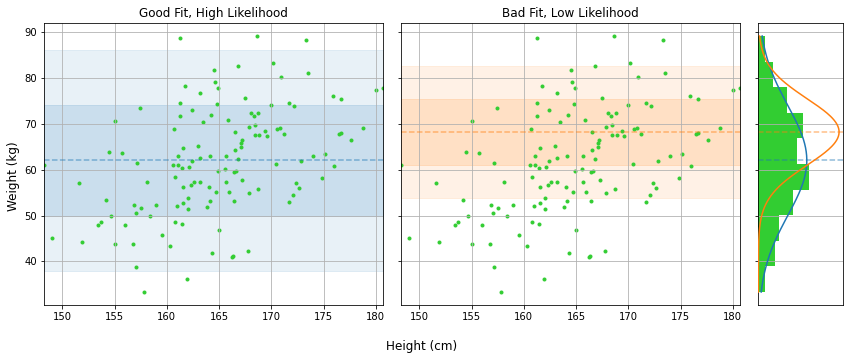

In [7]:
# REDACT
f, (a1,a2,a3) = plt.subplots(1,3, figsize=(12,5), sharex=False, sharey=True, gridspec_kw={'width_ratios': [1, 1, 0.25]})

f.supxlabel("Height (cm)" ), f.supylabel("Weight (kg)")


for a, mua, siga, c in zip((a1,a2), (wav, wav*1.1), (wsig,wsig*0.6), ['tab:blue', 'tab:orange']):

    a.scatter(H,W, marker='.', c='limegreen')
    a.grid()

    Xplot = np.linspace(H.min(),H.max(), 5)
    a.plot(Xplot,np.ones_like(Xplot) * mua, alpha=0.5, c=c, ls='--')
    a.fill_between(Xplot, np.ones_like(Xplot) * (mua-siga), np.ones_like(Xplot) * (mua+siga), zorder=-5, alpha=0.15, color=c)
    a.fill_between(Xplot, np.ones_like(Xplot) * (mua-siga*2), np.ones_like(Xplot) * (mua+siga*2), zorder=-10, alpha=0.1, color=c)

    a.set_xlim(Xplot.min(), Xplot.max())

    Y = np.linspace(W.max(),W.min(), 256)
    
    a3.plot(np.exp(-( (Y-mua)/siga)**2/2) / np.sqrt(2*siga**2*np.pi) , Y, zorder=100, c=c)
    a3.axhline(mua, ls='--', c=c, alpha=0.5)

a3.hist(W, orientation='horizontal', color='limegreen', density=True, bins = None)

a1.set_title("Good Fit, High Likelihood")
a2.set_title("Bad Fit, Low Likelihood")
a3.set_xticks([])
a3.grid()
plt.plot()
f.tight_layout()
plt.show()

For proper bayesian modeling we also need to put some prior constraints on $\mu$ and $\sigma$. The "correct" way to do this would be to use constraints from some prior studies on the matter, but in this case we can just make some common-sense guesses. People tend to weigh $\approx 50-150 \mathrm{kg}$, so we can make an arbitrary but sufficiently vague guess that:

$$
\mu \in [50,100], \;\;\;
\sigma \in [10,100]
$$

Or, more rigorously describing this as a [uniform prior](https://en.wikipedia.org/wiki/Continuous_uniform_distribution):

$$
\pi(\mu,\sigma) = \frac{1 
}{(100-50)\times (100-5)}
\begin{cases}
    1, \; \mu \in [50,100] \; \& \; \sigma \in [5,50]\\
    0, \; \mathrm{Otherwise}
\end{cases}
$$

In a simple case like this, it's no trouble at all to implement these as python functions:

In [8]:
def log_likelihood_one(H, W, mu, sig):
    chi2 = ( (W-mu) / sig )**2
    out = - chi2 / 2 - np.log(sig) - np.log(2*np.pi)/2
    return(out.sum())

def prior_one(mu, sig):
    out = (mu>50) * (mu<100)
    out*= (sig>5) * (sig<50)
    out = out * 1 / (100-50) / (50-5)
    return(out)

def post_density_one(H,W, mu, sig):
    out = prior_one(mu,sig) * np.exp(log_likelihood_one)
    return(out)

This posterior density, here encoded in the function `post_density_one`, can be evaluated throughout parameter space, i.e. testing different values of $\mu$ and $\sigma$, to find what combinations best reflect reality.

/tmp/ipykernel_21628/2687195259.py:8: RuntimeWarning: divide by zero encountered in log
  density[i,j] = np.log(prior_one(mu,sig)) + log_likelihood_one(H,W,mu,sig)


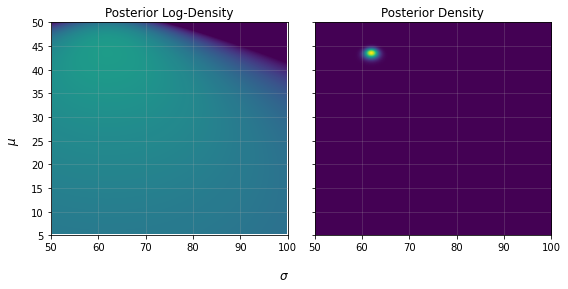

In [9]:
# REDACT
MU, SIG = np.linspace(50,100,512), np.linspace(5,50,256)

density = np.zeros([len(MU),len(SIG)])
for i in range(len(MU)):
    for j in range(len(SIG)):
        mu, sig = MU[i], SIG[j]
        density[i,j] = np.log(prior_one(mu,sig)) + log_likelihood_one(H,W,mu,sig)

#----------------------------------------------
f, (a1,a2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(8,4))
a1.imshow(density.T, vmin= -1000, vmax=-100, extent = [MU.min(), MU.max(), SIG.min(), SIG.max()])
a2.imshow(np.exp(density.T), extent = [MU.min(), MU.max(), SIG.min(), SIG.max()])
a1.set_title("Posterior Log-Density")
a2.set_title("Posterior Density")

f.supxlabel("$\sigma$"), f.supylabel("$\mu$")
f.tight_layout()
a1.grid(alpha=0.25), a2.grid(alpha=0.25)
plt.show()

This is the general procedure for all bayesian fitting: have some generative model with a series of tuning parameters, and then find the locations in parameter space that do the best job of explaining / replicating our observed data. Here we only have two parameters, and so could get away with plotting as a 2D heat-map, but this basic idea can extend to as many parameters/dimensions as you want. Common practice is to use a package like [`ChainConsumer`](https://samreay.github.io/ChainConsumer/) to make a `corner plot', which shows the posterior density after you integrate / [marginalize](https://en.wikipedia.org/wiki/Marginal_distribution) over all other parameters:  

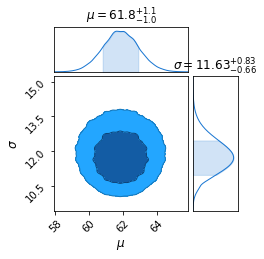

In [10]:
# REDACT
C = ChainConsumer()
A,B = np.meshgrid(MU,SIG)
chain = {'$\mu$': A.reshape(len(MU)*len(SIG)), 
         '$\sigma$': B.reshape(len(MU)*len(SIG))
        }
C.add_chain(chain, weights = np.exp(density.T.reshape(len(MU)*len(SIG))))
C.plotter.plot()
plt.show()

It's also common to use [certain algorithms](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) to do the actual like-lihood evaluation in a way that doesn't waste computations on the un-interesting "flat-land" at low likelihood. I won't cover these here, as they're really more a numerical concept than a statistical one, but tool-sets like [`emcee`](https://emcee.readthedocs.io/en/stable/) and [`NumPyro`](https://num.pyro.ai/) let us apply Bayesian model fitting in a really easy and flexible way.

**Model 2: Linear**  
For a linear regression, we again need to be specific about what distribution we think the weights are drawn from. In this case, we'll say "the weight is drawn from some normal distribution with a mean that varies linearly with height":

$$
W_i \sim \mathcal{N}(m \cdot H_i + c, \; \sigma)
$$

Meaning we again get a likelihood function that describes how _likely_ any given measurement $(W_i,H_i)$ is for some parameters $(m,c,\sigma)$:

$$
\mathcal{L}_i(m, c, \sigma) = P(W_i \vert m, c,\sigma)= \frac{1}{\sqrt{2\pi\sigma^2}}  \exp{\left(- \frac{1}{2} \left( \frac{W_i-(m\cdot H_i + c)}{\sigma} \right)^2 \right)}
$$

And again, some sort of log-likelihood for _all_ measurements:

$$
LL = \ln{\mathcal{L}}(\mu, \sigma) =-\frac{1}{2} \sum_i {\left(  \frac{x_i-(m\cdot H_i+c)}{\sigma} \right)^2}   - N \ln{\sigma}-\frac{N}{2} \ln{2\pi}
$$

Where things get a little tricky is defining priors in a principled way. Before, we could at least take a _rough_ guess about the average and scatter in weights, but I don't have any physical intuition as to what "slopes" and "offsets" are reasonable<sup>Note</sup>.  Instead, I'm going to cheat a little bit and just set a deliberately vague and somewhat arbitrary prior:

$$
m \in [0,2], \;\; c\in[-1000, 1000], \;\; \sigma\in[5,50]
$$

Again, I'll treat these as being uniform distributions:

$$
\pi(m, c,\sigma) = \frac{1 
}{ (100-50)\times (100-5) \times ()}
\begin{cases}
    1, \; m \in [0,1] \; \& \; c \in [-1,000,1,000] \; \& \; \sigma \in [5,50]\\
    0, \; \mathrm{Otherwise}
\end{cases}
$$

>Note: A better way to do this would be to re-frame slope and offset in terms of the mean height/weight and their [_correlation_](https://en.wikipedia.org/wiki/Correlation), which we could put more reasonable boundary of $[0\%-100\%]$ on.

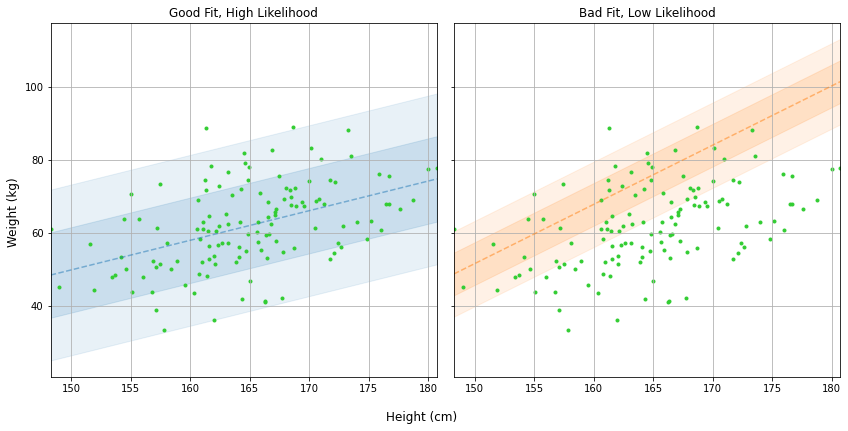

In [13]:
# REDACT
f, (a1,a2) = plt.subplots(1,2, figsize=(12,6), sharex=False, sharey=True)

f.supxlabel("Height (cm)" ), f.supylabel("Weight (kg)")


for a, ma, ca, siga, c in zip((a1,a2), (mfreq, mfreq*2.0), (cfreq, cfreq - 120), (sigmafreq, sigmafreq/2), ['tab:blue', 'tab:orange']):

    a.scatter(H,W, marker='.', c='limegreen')
    a.grid()

    Xplot = np.linspace(H.min(),H.max(), 5)
    a.plot(Xplot, Xplot*ma + ca, alpha=0.5, c=c, ls='--')
    a.fill_between(Xplot, Xplot*ma + ca - siga, Xplot*ma + ca + siga, zorder=-5, alpha=0.15, color=c)
    a.fill_between(Xplot, Xplot*ma + ca - siga*2, Xplot*ma + ca + siga*2, zorder=-10, alpha=0.1, color=c)

    a.set_xlim(Xplot.min(), Xplot.max())

    Y = np.linspace(W.max(),W.min(), 256)
    
    
a3.hist(W, orientation='horizontal', color='limegreen', density=True, bins = None)

a1.set_title("Good Fit, High Likelihood")
a2.set_title("Bad Fit, Low Likelihood")

plt.plot()
f.tight_layout()
plt.show()

Again, it's pretty straightforward to encode this mathematically in python. We just need a prior function and a likelihood function:

In [14]:
def log_likelihood_two(X, Y, m,c,sig):
    Y_pred = m*X + c
    chi2 = (Y-Y_pred)**2 / sig**2
    out = - chi2 / 2 - np.log(sig) - np.log(2*np.pi)/2
    return(out.sum())
    
def prior_two(m, c, sig):
    out = (m>0) * (m<2)
    out*= (c>-1000) * (c<1000)
    out*= (sig>5) * (sig<50)
    out = out * 1 / (1000 - (-1000) ) / (2-0) / (50-5)
    return(out)

def post_density_two(H, W, m, c, sig):
    out = prior_two(m, c, sig) * np.exp(log_likelihood_two)
    return(out)

The moment you get beyond one or two dimensions, its almost impossible to evaluate posterior densities with brute force. Instead, I'll demonstrate here how to use `emcee`, probably the most popular python package for mapping out Bayesian likelihood contours. `emcee` is an implementation of the [Affine Invariant Ensemble Sampler](https://msp.org/camcos/2010/5-1/camcos-v5-n1-p04-p.pdf), which throws down a cloud of "walkers" in parameter space that shimmy about until they follow the shape of the posterior distribution. Using it is as simple as defining a function for the overall log posterior density, giving start positions for the walkers, then firing the sampler off to run:

In [16]:
import emcee

#-------------------
# It's common to us the greek 'theta' (Θ) to denote the set of model parameters
def log_prob(theta):
    m, c, sig = theta

    LL = log_likelihood_two(H, W, m, c, sig)
    P = prior_two(m, c, sig)
    
    if (P==0): 
        LP = -np.inf
    else:
        LP = np.log(P)
    
    return(  LL + LP )

#-------------------
# We have 3 dimensions, and I want 32 walkers
ndim, nwalkers = 3, 32

# Generate starting positions. 
# Start at our best guesses for slope, offset and scatter from the frequentist fit
p0 = np.tile([mfreq, cfreq, sigmafreq], (nwalkers,1))
# Then add a little scatter to them
p0+=np.random.randn(*p0.shape)/10

#-------------------
# Now run the sampler!
print("Starting run!")
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=None)
%time sampler.run_mcmc(p0, 10_000)
print("Done!")

Starting run!
CPU times: user 8.8 s, sys: 1.14 ms, total: 8.8 s
Wall time: 8.8 s
Done!


Now we can grab the results as a chain, trimming off the first `1_000` entries that the sampler needs to settle in during the "burn-in" phase, and use `chainconsumer` to plot the results. This is a pretty typical workflow for Bayesian model fitting: make a model, run it through some kind of sampler and throw into a plotter.

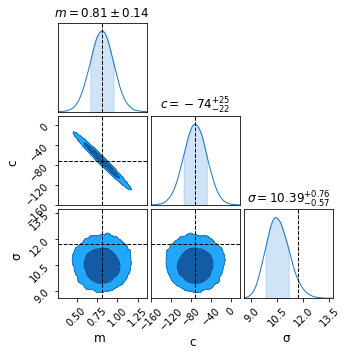

In [18]:
results = sampler.get_chain(discard=1_000, thin=4, flat=True)
Ch = ChainConsumer()
chain = {'m': results[:,0], 
         'c': results[:,1],
         'σ': results[:,2]
        }

Ch.add_chain(chain)
Ch.plotter.plot(truth = {'m': mfreq, 'c': cfreq, 'σ': sigmafreq})
plt.show()

### Comparison
To summarize the big differences in the two approaches:
* Frequentism answers yes/no questions about whether a model meaningfully improves your predictions, and has a variety of tools for specific problems. It doesn't require us to make too many assumptions about the model, or to incorporate prior knowledge.
* Bayesianism lets us precisely constrain what we know about the world, but requires us to fully state our model of reality, including the mechanics that generate observations and our prior beliefs about them. 